# Hysteresis loop simulation
The notebook shows how to run micromagnetic simulations to obtain a hysteresis loop for a magnetic material. The workflow involves defining a:
- **geometry and mesh** which discretizes the material into cells for numerical calculations, and also defines sub-regions within the material.
- **micromagnetic material parameters** corresponding to different sub-regions.
- **simulation parameters** which control the simulation algorithms.

All of the above mentioned definitions are used to create a simulation object which will be used to actually run the hysteresis loop simulation. The simulation run will store magnetization configuration in `vtu` file(s). Further, it will create a `csv` file that contains magnitude of external field, magnetization in the direction of the external field, components of average magnetization, and total energy. Finally, the simulation run stores the time and version of `mammos_mumag` in an `info.json` file.

In [1]:
import mammos_entity as me
import mammos_units as u
from mammos_mumag.hysteresis import read_result
from mammos_mumag.materials import Materials
from mammos_mumag.mesh import Mesh
from mammos_mumag.parameters import Parameters
from mammos_mumag.simulation import Simulation

u.set_enabled_equivalencies(u.magnetic_flux_field());

## Inputs

### Geometry and Mesh

We load one of the meshes coming with `mammos_mumag`, `cube20_singlegrain_msize2`, defining a cube of length 20 with no grains and a mesh size of 2. The cube is surrounded by a shell and non-magnetic material in between the material cube and the shell. This is done is order to calculate demagnetization field which decays to zero at infinity. For details: Imhoff, J. F., et al. "An original solution for unbounded electromagnetic 2D-and 3D-problems throughout the finite element method." IEEE Transactions on Magnetics 26.5 (1990): 1659-1661.

In [2]:
mesh = Mesh("cube20_singlegrain_msize2")

### Material parameters

We define the material parameters separately for the 3 domains: the magnetic material, the non-magnetic material and the shell. Therefore the parameters strictly related to the magnetic material will be only defined on the first domain. The other domains will have magnetic properties equal to zero.

Here:
- **`theta`** is the polar angle of the magneto-crystalline anisotropy with respect to z-axis.
- **`phi`** is the azimuthal angle of the magneto-crystalline anisotropy in the xy-plane with respect to x-axis.
- **`K1`** is the first order magneto-crystalline anisotropy constant.
- **`K2`** is the second order magneto-crystalline anisotropy constant.
- **`Ms`** is the spontaneous magnetization.
- **`A`** is the exchange stiffness constant.

In [3]:
mat = Materials(
    domains=[
        {  # cube
            "theta": 0.0,
            "phi": 0.0,
            "K1": me.Ku(2.8e6, unit=u.J / u.m**3),
            "K2": me.Ku(0.0, unit=u.J / u.m**3),
            "Ms": me.Ms(1.19e6, unit=u.A / u.m),
            "A": me.A(6.01e-12, unit=u.J / u.m),
        },
        {  # non-magnetic material
            "theta": 0.0,
            "phi": 0.0,
            "K1": me.Ku(0.0, unit=u.J / u.m**3),
            "K2": me.Ku(0.0, unit=u.J / u.m**3),
            "Ms": me.Ms(0.0, unit=u.A / u.m),
            "A": me.A(0.0, unit=u.J / u.m),
        },
        {  # shell
            "theta": 0.0,
            "phi": 0.0,
            "K1": me.Ku(0.0, unit=u.J / u.m**3),
            "K2": me.Ku(0.0, unit=u.J / u.m**3),
            "Ms": me.Ms(0.0, unit=u.A / u.m),
            "A": me.A(0.0, unit=u.J / u.m),
        },
    ],
)

### Simulation parameters

We finally define all the simulation parameters we will use. For an exhaustive explanation of these parameters, check [the documentation](https://mammos-project.github.io/mammos/api/mammos_mumag.parameters.html#mammos_mumag.parameters.Parameters).

In [4]:
par = Parameters(
    size=1.0e-9,
    scale=0,
    m_vect=[0, 0, 1],
    h_start=(10 * u.T).to("A/m"),
    h_final=(-10 * u.T).to("A/m"),
    h_step=(-2 * u.T).to("A/m"),
    h_vect=[0.01745, 0, 0.99984],
    m_step=(0.4 * u.T).to("A/m"),
    m_final=(-1.2 * u.T).to("A/m"),
    tol_fun=1e-10,
    tol_h_mag_factor=1,
    precond_iter=10,
)

## Simulation object

To define a `Simulation` object, we need to define a mesh, a `Materials` object, and a `Parameters` object as shown above.

In [5]:
sim = Simulation(
    mesh=mesh,
    materials=mat,
    parameters=par,
)

Note that all of this could also have been defined using file paths:
```python
sim = Simulation(
    mesh=Mesh("./mesh.fly"),
    materials_filepath="./material.krn",
    parameters_filepath="./sim-settings.p2",
)
```

## Hysteresis loop calculation

To compute the demagnetization curve, we use `sim.run_loop` method. Here, we can specify the optional argument `outdir` and `name`. While the first identifies the output directory where the input and output files will be stored (also where the script is executed), the `name` argument defines the names of the output files.

The `outdir` argument can be used to give an ID to the simulation.

In [6]:
sim.run_loop(outdir="out/loop", name="cube")

The `out/loop` directory looks like:
```console
$> tree out/loop/
out/loop
├── cube_0001.vtu
├── cube_0002.vtu
├── cube.csv
├── cube.fly
├── cube.krn
├── cube.p2
├── cube_stats.txt
└── info.json
```

## Simulation results
The simulation results can be loaded into a `mammos_mumag.hysteresis.Result` object using `mammos_mumag.hysteresis.read_result` function.

In [7]:
results = read_result(outdir="out/loop", name="cube")
results

Result(H=Entity(ontology_label='ExternalMagneticField', value=array([ 7957747.15026276,  6366197.72021021,  4774648.29015766,
        3183098.86010511,  1591549.43005255,        0.        ,
       -1591549.43005255, -3183098.86010511, -4774648.29015766]), unit='A / m'), M=Entity(ontology_label='SpontaneousMagnetization', value=array([ 1189898.9481906 ,  1189866.40526925,  1189815.11921464,
        1189727.28638435,  1189557.43497599,  1189157.86904957,
        1187783.07668437,  1164137.60418793, -1189815.1228945 ]), unit='A / m'), Mx=Entity(ontology_label='SpontaneousMagnetization', value=array([ 1.40977658e+04,  1.30478457e+04,  1.16056500e+04,  9.50089294e+03,
        6.14117264e+03, -7.34109511e+01, -1.54960020e+04, -1.47662455e+05,
       -1.16058801e+04]), unit='A / m'), My=Entity(ontology_label='SpontaneousMagnetization', value=array([  -47.99514144,   -55.4713862 ,   -65.7111453 ,   -80.59786012,
        -104.24878947,  -147.68486853,  -254.6017913 , -1655.25070268,
          6

The `Result` object stores the magnitude of external magnetic field along a direction defined using `h_vect` in `Parameters` object, the magnitude of spontaneous magnetization along the same direction, and total energy density of the system as `mammos_entity.Entity` objects. 

In [8]:
results.H

Entity(ontology_label='ExternalMagneticField', value=array([ 7957747.15026276,  6366197.72021021,  4774648.29015766,
        3183098.86010511,  1591549.43005255,        0.        ,
       -1591549.43005255, -3183098.86010511, -4774648.29015766]), unit='A / m')

In [9]:
results.M

Entity(ontology_label='SpontaneousMagnetization', value=array([ 1189898.9481906 ,  1189866.40526925,  1189815.11921464,
        1189727.28638435,  1189557.43497599,  1189157.86904957,
        1187783.07668437,  1164137.60418793, -1189815.1228945 ]), unit='A / m')

In [10]:
results.energy_density

Entity(ontology_label='EnergyDensity', value=array([-14435045.7150797 , -12055278.0880263 ,  -9675592.39554646,
        -7296041.45406551,  -4916736.1890445 ,  -2537956.76779954,
         -160685.1661964 ,   2205885.87471876,  -9675592.39554454]), unit='J / m3')

It is also possible to convert the data points of the outputs into a `pandas.DataFrame`.

In [11]:
results.dataframe

,configuration_type,H,M,Mx,My,Mz,energy_density
0,1,7.957747e+06,1.189899e+06,14097.765759,-47.995141,1.189834e+06,-1.443505e+07
1,1,6.366198e+06,1.189866e+06,13047.845667,-55.471386,1.189820e+06,-1.205528e+07
2,1,4.774648e+06,1.189815e+06,11605.649969,-65.711145,1.189794e+06,-9.675592e+06
3,1,3.183099e+06,1.189727e+06,9500.892936,-80.597860,1.189743e+06,-7.296041e+06
4,1,1.591549e+06,1.189557e+06,6141.172644,-104.248789,1.189631e+06,-4.916736e+06
5,1,0.000000e+00,1.189158e+06,-73.410951,-147.684869,1.189340e+06,-2.537957e+06
6,1,-1.591549e+06,1.187783e+06,-15496.002030,-254.601791,1.188234e+06,-1.606852e+05
7,1,-3.183099e+06,1.164138e+06,-147662.454940,-1655.250703,1.166892e+06,2.205886e+06
8,2,-4.774648e+06,-1.189815e+06,-11605.880141,65.729490,-1.189794e+06,-9.675592e+06


- `configuration_type`: the id of the magnetization vector field appended to the `vtu` file name. The `vtu` files contain the magnetization corresponding to the row where the given value of `idx` was first observed.
- `H`: the value of the external field ($H_{\mathsf{ext}}$) in A/m.
- `M`: the magnitude of average spontaneous magnetization ($M_s$), in A/m, parallel to the direction of the external field.
- `Mx`: the component of average magnetization in x direction in A/m.
- `My`: the component of average magnetization in y direction in A/m.
- `Mz`: the component of average magnetization in z direction in A/m.
- `energy_density`: the energy density (in J/m$^3$) of the current state.

To plot the hysteresis curve, use `plot` method of the `Result` object.

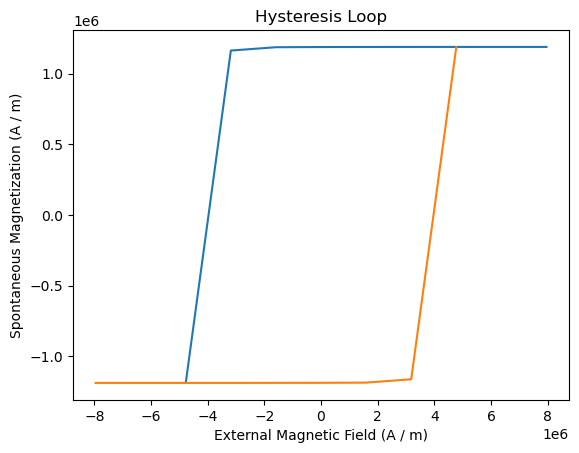

In [12]:
results.plot();

>**NOTE:** the orange curve in the plot above is artificially added to complete a full hysteresis loop. whether to show it or not can be controlled by the `duplicate` parameter of the `plot` method.

The `Result` object also contains the magnetization configurations corresponding to the different `configuration_types`.

In [13]:
results.configurations

{1: PosixPath('/home/pepe/repo/mammos/mammos-mumag/examples/out/loop/cube_0001.vtu'),
 2: PosixPath('/home/pepe/repo/mammos/mammos-mumag/examples/out/loop/cube_0002.vtu')}

To plot the configurations, use `plot_configuration` method of the `Result` object.

In [14]:
results.plot_configuration(2)

Widget(value='<iframe src="http://localhost:33679/index.html?ui=P_0x7bb55ba3bd50_0&reconnect=auto" class="pyvi…

> **NOTE:** It is important to note that there is a convenience function [mammos_mumag.hysteresis.run](https://mammos-project.github.io/mammos/examples/mammos-mumag/quickstart.html#mammos_mumag-quickstart) that does not require the user to input detailed material and simulation parameters to run hysteresis simulations.